In [3]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [4]:
from comet_ml import Experiment

/Users/user/miniconda3/envs/birds/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


<IPython.core.display.Javascript object>

In [8]:
DATA_DIR = "data"

<IPython.core.display.Javascript object>

In [12]:
import os
import warnings
import glob

<IPython.core.display.Javascript object>

In [10]:
os.listdir(DATA_DIR)

['.DS_Store', 'bird', 'non-bird']

<IPython.core.display.Javascript object>

In [13]:
img_list = glob.glob(os.path.join(DATA_DIR, "*/*.jpg"))

print(len(img_list))

22263


<IPython.core.display.Javascript object>

In [7]:
#experiment = Experiment(
#    project_name="bird-vs-not-bird", api_key="vXmIzDFObhyfUYzH4JUg8rOQp"
#)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gaiar/bird-vs-not-bird/b9b97d0ef48544169796495dd5a4e951



<IPython.core.display.Javascript object>

In [18]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img,
)

Using TensorFlow backend.


<IPython.core.display.Javascript object>

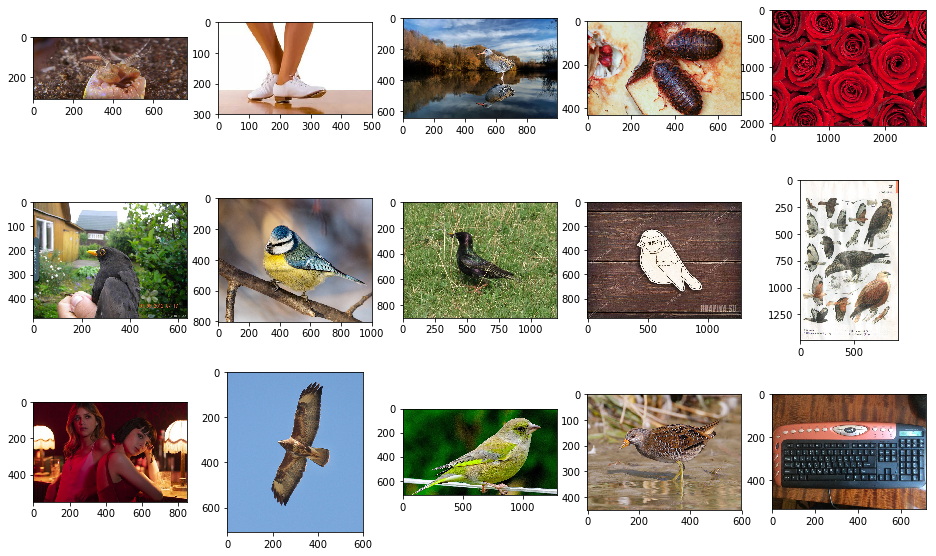

<IPython.core.display.Javascript object>

In [28]:
fig = plt.gcf()
fig.set_size_inches(16, 10)
for i, img_path in enumerate(random.sample(img_list, 15)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img.squeeze())

In [29]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import MobileNet, imagenet_utils
from keras.applications.mobilenet import preprocess_input
from keras import callbacks
from keras.callbacks import EarlyStopping
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

<IPython.core.display.Javascript object>

In [9]:
params = {}


params["batch_size"] = 96
params["num_classes"] = 2
params["epochs"] = 100
params["optimizer"] = "adam"
params["activation"] = "relu"
params["validation_split"] = 0.2
params["lr"] = 1e-3
params["kernel_initializer"] = "he_uniform"

<IPython.core.display.Javascript object>

In [10]:
def prepare_image(file):
    img_path = ""
    img = keras.preprocessing.image.load_img(img_path + file, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

<IPython.core.display.Javascript object>

In [11]:
def get_model(params):
    base_model = MobileNet(
        weights="imagenet", include_top=False
    )  # imports the mobilenet model and discards the last 1000 neuron layer.

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(
        x
    )  # we add dense layers so that the model can learn more complex functions and classify for better results.
    x = Dense(1024, activation="relu")(x)  # dense layer 2
    x = Dense(512, activation="relu")(x)  # dense layer 3
    preds = Dense(params["num_classes"], activation="softmax")(
        x
    )  # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=preds)

    for layer in model.layers:
        layer.trainable = False

    # or if we want to set the first 20 layers of the network to be non-trainable
    for layer in model.layers[:20]:
        layer.trainable = False
    for layer in model.layers[20:]:
        layer.trainable = True

    return model

<IPython.core.display.Javascript object>

In [12]:
model = get_model(params)

Instructions for updating:
Colocations handled automatically by placer.


/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras/applications/mobilenet.py:224: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


<IPython.core.display.Javascript object>

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (Activation)      (None, None, None, 32)    0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
__________

<IPython.core.display.Javascript object>

In [17]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)  # included in our dependencies

<IPython.core.display.Javascript object>

In [18]:
valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=preprocess_input
)

<IPython.core.display.Javascript object>

In [19]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR + "/train",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="categorical",
    shuffle=True,
)

Found 17778 images belonging to 2 classes.


<IPython.core.display.Javascript object>

In [20]:
validation_generator = valid_datagen.flow_from_directory(
    DATA_DIR + "/valid",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=params["batch_size"],
    class_mode="categorical",
    shuffle=True,
)

Found 4489 images belonging to 2 classes.


<IPython.core.display.Javascript object>

In [21]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

<IPython.core.display.Javascript object>

In [22]:
model.compile(
    optimizer=params["optimizer"], loss="categorical_crossentropy", metrics=["accuracy"]
)

<IPython.core.display.Javascript object>

In [18]:
# experiment.display()

<IPython.core.display.Javascript object>

In [25]:
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

<IPython.core.display.Javascript object>

In [18]:
# experiment.display()

<IPython.core.display.Javascript object>

In [26]:
# log parameters in Comet.ml
experiment.log_parameters(params)

<IPython.core.display.Javascript object>

## Setup callbacks 

In [27]:
MODELS_DIR = "models"

<IPython.core.display.Javascript object>

In [29]:
log = callbacks.CSVLogger(os.path.join(MODELS_DIR, "bird-vs-not-bird-log.csv"))

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(MODELS_DIR, "bird-vs-not-bird-weights-{epoch:02d}.h5"),
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)
lr_decay = callbacks.LearningRateScheduler(
    schedule=lambda epoch: params["lr"] * (0.9 ** epoch)
)

early_stopping = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=5, verbose=1, mode="auto"
)

<IPython.core.display.Javascript object>

## Train the model

In [30]:
with experiment.train():
    step_size_train = train_generator.samples // params["batch_size"]
    history = model.fit_generator(
        generator=train_generator,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // params["batch_size"],
        steps_per_epoch=step_size_train,
        epochs=params["epochs"],
        verbose=1,
        callbacks=[log, checkpoint, lr_decay],
        use_multiprocessing=True,
        workers=7,
    )

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
185/185 [==============================] - 276s 1s/step - loss: 0.2385 - acc: 0.9119 - val_loss: 0.6746 - val_acc: 0.6073

Epoch 00001: val_loss improved from inf to 0.67455, saving model to models/bird-vs-not-bird-weights-01.h5
Epoch 2/100
185/185 [==============================] - 267s 1s/step - loss: 0.1488 - acc: 0.9435 - val_loss: 2.7891 - val_acc: 0.6089

Epoch 00002: val_loss did not improve from 0.67455
Epoch 3/100
185/185 [==============================] - 266s 1s/step - loss: 0.1280 - acc: 0.9524 - val_loss: 1.8238 - val_acc: 0.6105

Epoch 00003: val_loss did not improve from 0.67455
Epoch 4/100
185/185 [==============================] - 266s 1s/step - loss: 0.1053 - acc: 0.9610 - val_loss: 1.7667 - val_acc: 0.6089

Epoch 00004: val_loss did not improve from 0.67455
Epoch 5/100
185/185 [==============================] - 268s 1s/step - loss: 0.0890 - acc: 0.9684 - val_loss: 1.5075 - val_acc: 0.6087

Epoch 00005: val_loss did not improve from 0.67455
Epoch 6/100
185

Process ForkPoolWorker-271:
Process ForkPoolWorker-268:
Process ForkPoolWorker-270:
Process ForkPoolWorker-267:
Process ForkPoolWorker-272:
Process ForkPoolWorker-269:
Process ForkPoolWorker-273:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/gaiar/miniconda3/envs/birds/lib/python3.6/multipr

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [23]:
model.save_weights(os.path.join(MODELS_DIR, "mobilenet.bird-vs-not-bird.overfit.h5"))

<IPython.core.display.Javascript object>

In [24]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/gaiar/bird-vs-not-bird/47bd244dbdc8414d87eba743570937f7
COMET INFO:   Metrics:
COMET INFO:               sys.gpu.0.free_memory: 6122504192
COMET INFO:           sys.gpu.0.gpu_utilization: 0
COMET INFO:              sys.gpu.0.total_memory: 6370295808
COMET INFO:               sys.gpu.0.used_memory: 247791616
COMET INFO:                           train_acc: 0.9995038554426577
COMET INFO:                     train_batch_acc: 1.0
COMET INFO:                    train_batch_loss: 6.072286e-07
COMET INFO:                     train_epoch_end: 29
COMET INFO:                          train_loss: 0.0007431388909900903
COMET INFO:                          train_step: 6930
COMET INFO:         train_sys.gpu.0.free_memory: 94240768
COMET INFO:     train_sys.gpu.0.gpu_utilization: 100
COMET INFO:         train_sys.gpu.0.used_memory: 6276055040
COMET INFO:     

<IPython.core.display.Javascript object>

# Testing predictions

In [25]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import load_model
import scipy
import os

<IPython.core.display.Javascript object>

Connecting Google Drive with saved model

In [69]:
IMAGES_DIR = "/home/gaiar/developer/birds-of-berlin/datasets/data"

<IPython.core.display.Javascript object>

In [70]:
MODELS_DIR = "models"

<IPython.core.display.Javascript object>

In [28]:
model = get_model(params)

/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/keras/applications/mobilenet.py:224: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


<IPython.core.display.Javascript object>

In [29]:
model.load_weights(os.path.join(MODELS_DIR, "bird-vs-not-bird-weights-30.h5"))

<IPython.core.display.Javascript object>

In [42]:
def load_image(img_path, show=False):
    img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_tensor = keras.preprocessing.image.img_to_array(
        img
    )  # (height, width, channels)
    img_tensor = np.expand_dims(
        img_tensor, axis=0
    )  # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.0  # imshow expects values in the range [0, 1]
    if show:
        plt.imshow(img_tensor[0])
        plt.axis("off")
        plt.show()
    return img_tensor

<IPython.core.display.Javascript object>

In [31]:
labels = validation_generator.class_indices
labels

{'bird': 0, 'non-bird': 1}

<IPython.core.display.Javascript object>

In [32]:
import os

<IPython.core.display.Javascript object>

In [89]:
test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    IMAGES_DIR, target_size=(224, 224), batch_size=params["batch_size"]
)

Found 10628 images belonging to 84 classes.


<IPython.core.display.Javascript object>

In [91]:
import math

steps = test_batches.samples / params["batch_size"]

<IPython.core.display.Javascript object>

In [129]:
predictions = model.predict_generator(
    test_batches,
    max_queue_size=params["batch_size"] * 2,
    verbose=1,
    workers=7,
    steps=steps,
    use_multiprocessing=True,
)

111/110 [==============================] - 91s 823ms/step


<IPython.core.display.Javascript object>

In [149]:
images = []
i = 0
for root, dirs, files in os.walk(IMAGES_DIR):
    for filename in files:
        if i <= 199999:
            try:
                img = os.path.join(root, filename)
                new_image = prepare_image(img)
                y_prob = model.predict(new_image)
                y_classes = y_prob.argmax(axis=-1)
                if y_classes[0] == 1:
                    images.append(img)
                    i += 1
            except Exception as e:
                print("Error reading image {0} {1}".format(filename, e))
                pass
        else:
            break

/home/gaiar/miniconda3/envs/birds/lib/python3.6/site-packages/PIL/Image.py:2655: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Error reading image wanderfalke_6288_13.webp cannot identify image file '/home/gaiar/developer/birds-of-berlin/datasets/data/Wanderfalke/wanderfalke_6288_13.webp'


<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(300, 300))
columns = 4
for i, img in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(mpimg.imread((img)))

In [ ]:
from IPython.display import Image
from IPython.display import display

# x = Image(filename='1.png')
imgs = []
imgs = [Image(filename=img) for img in images]

display(*imgs)

In [ ]:
#So first of all the test images should be placed inside a separate folder inside the test folder. So in my case I made another folder inside test folder and named it all_classes. Then ran the following code:

test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(28, 28),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

#The above code gives me an output:
#Found 306 images belonging to 1 class

#And most importantly you've to write the following code:

test_generator.reset()

#else weird outputs will come. Then using the .predict_generator() function:

pred=cnn.predict_generator(test_generator,verbose=1,steps=306/batch_size)

#Running the above code will give output in probabilities so at first I need to convert them to class number. In my case it was 4 classes, so class numbers were 0,1,2 and 3.

Code written:

predicted_class_indices=np.argmax(pred,axis=1)

#Next step is I want the name of the classes:

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#Where by class numbers will be replaced by the class names. One final step if you want to save it to a csv file, arrange it in a dataframe with the image names appended with the class predicted.

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

#Display your dataframe. Everything is done now. You get all the predicted class for your images.
